## 概述

在做特征工程遇到类别变量时，需要把其编码为数值变量。

有一点要注意的：就是保留训练集的编码字典，以在后续对数据预测时，保持编码一致！

常见的有如下的场景：

* one-hot
最常见的。

* 顺序编码
对于有顺序的类别。如一级二级三级等

* 把类别编码数字

## 难点：超多类别(如超过100类)的分类特征的处理

https://mp.weixin.qq.com/s/guh05AZoKoc1xgApNRl99Q
### XGBoost之类别特征的处理

https://www.biaodianfu.com/categorical-features.html

无论是XGBoost还是其他的Boosting Tree，使用的Tree都是cart回归树，这也就意味着该类提升树算法只接受数值特征输入，不直接支持类别特征，默认情况下，xgboost会把类别型的特征当成数值型。事实上，对于类别特征的处理，参考XGBoost PPT如下：
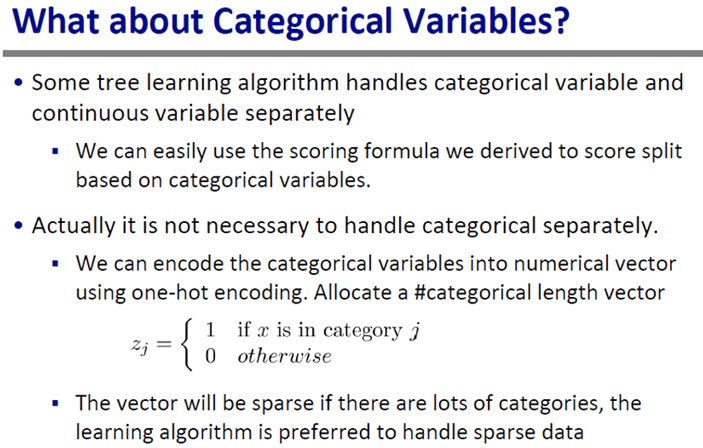

在另一个issues上也提到过（tqchen commented on 8 May 2015）：

    One-hot encoding could be helpful when the number of categories are small( in level of 10 to 100). In such case one-hot encoding can discover interesting interactions like (gender=male) AND (job = teacher).

    While ordering them makes it harder to be discovered(need two split on job). However, indeed there is not a unified way handling categorical features in trees, and usually what tree was really good at was ordered continuous features anyway..

In [1]:
import pandas as pd
import sys
sys.path.append('/Users/luoyonggui/PycharmProjects/mayiutils_n1/mayiutils/data_prepare')


In [2]:
from cat_feature_encoder import CatFeatureEncoder as cfe

## one-hot 编码

### pd.get_dummies
这样的处理，对于新来的预测数据怎么能保持编码和处理训练集时的编码一致？！

In [3]:
s = pd.Series(['a', 'b', None, 'a', 'c'])

In [4]:
pd.get_dummies(s)

,a,b,c
0,1,0,0
1,0,1,0
2,0,0,0
3,1,0,0
4,0,0,1


In [42]:
df = pd.DataFrame({'c1': ['a', 'b', None, 'a', 'c'],
                  'c2': ['a', 'e', 'g', 'a', 'c']})

In [9]:
cfe.build_one_hot_features(df, ['c1', 'c2'])

,c1_a,c1_b,c1_c,c2_a,c2_c,c2_e,c2_g
0,1,0,0,1,0,0,0
1,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0
4,0,0,1,0,1,0,0


### OneHotEncoder
使用OneHotEncoder处理的结果为ndarray，

OneHotEncoder处理的df不能含有None值

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
df.dropna()

,c1,c2
0,a,a
1,b,e
3,a,a
4,c,c


In [36]:
OneHotEncoder().fit_transform(df.dropna()).toarray()

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.]])

In [63]:
OneHotEncoder(sparse=False).fit_transform(df.dropna())

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.]])

### LabelBinarizer
专门对label进行One-hot编码 
Note: a one-hot encoding of y labels should use a LabelBinarizer

In [64]:
from sklearn.preprocessing import LabelBinarizer

In [65]:
lb = LabelBinarizer()

In [66]:
lb.fit([1, 2, 6, 4, 2])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [67]:
lb.transform([1, 2, 6, 4, 2])

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

In [68]:
lb.fit_transform(['yes', 'no', 'no', 'yes'])

array([[1],
       [0],
       [0],
       [1]])

In [74]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


#### OneHotEncoder和LabelBinarizer的区别
OneHotEncoder必须接受2D数据

关键是对于二分类的特征或y，使用OneHotEncoder会生成互斥的两列，而LabelBinarizer更合理

In [72]:
import numpy as np

In [73]:
OneHotEncoder().fit_transform(np.array(['yes', 'no', 'no', 'yes']).reshape(-1, 1)).toarray()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

## 序数编码
和LabelEncoder的区别是可以按照指定的顺序进行编码

In [4]:
s = pd.Series(['a', 'b', 'c', 'a', None])

In [11]:
d = dict(zip(['a', 'b', 'c'], range(3)))

In [12]:
d

{'a': 0, 'b': 1, 'c': 2}

In [15]:
s.map(lambda x: d[x], na_action='ignore')

0    0.0
1    1.0
2    2.0
3    0.0
4    NaN
dtype: float64

In [5]:
cfe.ordinal_coding(s, ['a', 'b', 'c'])

0    0.0
1    1.0
2    2.0
3    0.0
4    NaN
dtype: float64

In [38]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


In [40]:
df.apply(lambda s: cfe.ordinal_coding(s, ['a', 'b', 'c', 'e', 'g']))

,c1,c2
0,0.0,0
1,1.0,3
2,NaN,4
3,0.0,0
4,2.0,2


In [76]:
from sklearn.preprocessing import OrdinalEncoder

In [80]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


### OrdinalEncoder

In [83]:
oe = OrdinalEncoder()

In [84]:
oe.fit_transform(df.dropna())

array([[0., 0.],
       [1., 2.],
       [0., 0.],
       [2., 1.]])

In [85]:
oe.categories_

[array(['a', 'b', 'c'], dtype=object), array(['a', 'c', 'e'], dtype=object)]

In [88]:
OrdinalEncoder([['a', 'b', 'c'], ['a', 'e',]]).fit_transform(df.dropna())

array([[0., 0.],
       [1., 1.],
       [0., 0.],
       [2., 2.]])

In [91]:
from sklearn.preprocessing import 

In [ ]:
MultiLabelBinarizer()

## 标签编辑器LabelEncoder
我们也可以使用标签编辑器将变量编码为数字。标签编辑器本质上做的是它看到列中的第一个值并将其转换成0，下一个值转换成1，依次类推。这种方法在树模型中运行得相当好，当我在分类变量中有很多级别时，可以使用它。

In [6]:
from sklearn.preprocessing import LabelEncoder

In [8]:
s

0       a
1       b
2       c
3       a
4    None
dtype: object

In [11]:
le = LabelEncoder()
le.fit_transform(s[:4])

array([0, 1, 2, 0])

In [13]:
le.classes_

array(['a', 'b', 'c'], dtype=object)

In [15]:
le.transform(s[:4])

array([0, 1, 2, 0])

In [16]:
le.inverse_transform([0, 1, 2, 0])

array(['a', 'b', 'c', 'a'], dtype=object)

### 多列数据如何进行方便的编码

#### 方案一：defaultdict

In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import pandas as pd
 
df = pd.DataFrame({
    'pets': ['cat', 'dog', 'cat', 'monkey', 'dog', 'dog'],
    'owner': ['Champ', 'Ron', 'Brick', 'Champ', 'Veronica', 'Ron'],
    'location': ['San_Diego', 'New_York', 'New_York', 'San_Diego', 'San_Diego',
                 'New_York']
})

可以这样做，但是有一个缺点是没有把LabelEncoder()实例保持下来，这样的话，如果预测时，怎样转换test_set会遇到麻烦！

In [25]:
df.apply(LabelEncoder().fit_transform)

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


With defaultdict, you now retain all columns LabelEncoder as dictionary.

In [18]:
d = defaultdict(LabelEncoder)

In [19]:
d

defaultdict(sklearn.preprocessing.label.LabelEncoder, {})

In [20]:
# Encoding the variable
fit = df.apply(lambda x: d[x.name].fit_transform(x))

In [21]:
fit

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


In [22]:
# Inverse the encoded
fit.apply(lambda x: d[x.name].inverse_transform(x))

,pets,owner,location
0,cat,Champ,San_Diego
1,dog,Ron,New_York
2,cat,Brick,New_York
3,monkey,Champ,San_Diego
4,dog,Veronica,San_Diego
5,dog,Ron,New_York


In [23]:
# Using the dictionary to label future data
df.apply(lambda x: d[x.name].transform(x))

,pets,owner,location
0,0,1,1
1,1,2,0
2,0,0,0
3,2,1,1
4,1,3,1
5,1,2,0


#### 方案2：Pipeline

In [47]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
# Create some toy data in a Pandas dataframe
fruit_data = pd.DataFrame({
    'fruit':  ['apple','orange','pear','orange'],
    'color':  ['red','orange','green','green'],
    'weight': [5,6,3,4]
})
 
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
 
    def fit(self,X,y=None):
        return self # not relevant here
 
    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output
 
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [48]:
MultiColumnLabelEncoder(columns = ['fruit','color']).fit_transform(fruit_data)

,fruit,color,weight
0,0,2,5
1,1,1,6
2,2,0,3
3,1,0,4


In [49]:
MultiColumnLabelEncoder().fit_transform(fruit_data.drop('weight',axis=1))

,fruit,color
0,0,2
1,1,1
2,2,0
3,1,0


Another nice feature about this is that we can use this custom transformer in a pipeline:


In [51]:
encoding_pipeline = Pipeline([
    ('encoding',MultiColumnLabelEncoder(columns=['fruit','color']))
    # add more pipeline steps as needed
])
encoding_pipeline.fit_transform(fruit_data)

,fruit,color,weight
0,0,2,5
1,1,1,6
2,2,0,3
3,1,0,4


In [53]:
df

,c1,c2
0,a,a
1,b,e
2,None,g
3,a,a
4,c,c


### df category 
空值编码为-1

In [54]:
df.c1.astype('category')

0      a
1      b
2    NaN
3      a
4      c
Name: c1, dtype: category
Categories (3, object): [a, b, c]

In [56]:
df.c1.astype('category').cat.codes

0    0
1    1
2   -1
3    0
4    2
dtype: int8

In [52]:
pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)

,c1,c2
0,0,0
1,1,2
2,-1,3
3,0,0
4,2,1


To create a mapping dictionary, you can just enumerate the categories using a dictionary comprehension:

In [57]:
{col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}

{'c1': {0: 'a', 1: 'b', 2: 'c'}, 'c2': {0: 'a', 1: 'c', 2: 'e', 3: 'g'}}

## 二进制编码器

二进制编码器是另一种可用于对分类变量进行编码的方法。如果一个列中有多个级别，那么这是一种很好的方法。虽然我们可以使用一个热编码来对使用1023列的具有1024个级别的列进行编码，但是使用二进制编码，我们可以通过使用10列来完成。

In [14]:
!pip install category_encoders

     |████████████████████████████████| 92kB 490kB/s eta 0:00:01


In [15]:
from category_encoders.binary import BinaryEncoder

In [17]:
be = BinaryEncoder(cols=['a'])

In [19]:
df = pd.DataFrame(pd.Series(range(16)), columns=['a'])

In [20]:
be.fit_transform(df)

,a_0,a_1,a_2,a_3,a_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,1,0,1
5,0,0,1,1,0
6,0,0,1,1,1
7,0,1,0,0,0
8,0,1,0,0,1
9,0,1,0,1,0


## 哈希散列编码器



可以将哈希散列编码器视为一个黑盒函数，它将字符串转换为0到某个预定值之间的数字。



它与二进制编码器不同，因为在二进制编码中，两个或多个俱乐部参数可能是1，而在哈希散列中只有一个值是1。



我们可以像这样使用哈希散列：

In [21]:
from category_encoders.hashing import HashingEncoder

In [22]:
he = HashingEncoder(cols=['a'])

In [23]:
he.fit_transform(df)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0
6,0,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0


一定会有冲突（两个俱乐部有相同的编码。例如，尤文图斯足球俱乐部和巴黎圣日耳曼足球俱乐部具有相同的编码），但有时这种技术效果很好。